<a href="https://colab.research.google.com/github/helenamartinez/UFMS/blob/main/video_game_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O Problema de Negócio: A indústria de videogames movimenta bilhões de dólares. Para editoras e investidores, estimar o sucesso comercial de um jogo antes ou durante seu lançamento é crucial para alocação de marketing e previsão de receita.

O Objetivo: Desenvolver um modelo de Machine Learning capaz de prever o volume de Vendas Globais (Global_Sales) de um título, baseando-se em metadados como Plataforma, Gênero, Editora e Ano de Lançamento.

Tipo de Problema: Regressão (pois a saída é um número contínuo).

--- Dimensões do Dataset ---
(16598, 11)

--- Tipos de Variáveis e Nulos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None

Dimensões após limpeza: (16291, 11)


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,0.265647,0.147731,0.078833,0.048426,0.540910
std,0.822432,0.509303,0.311879,0.190083,1.567345
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.040000,0.480000
max,41.490000,29.020000,10.220000,10.570000,82.740000


/tmp/ipython-input-2125066424.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_genre.index, y=sales_by_genre.values, palette='viridis')


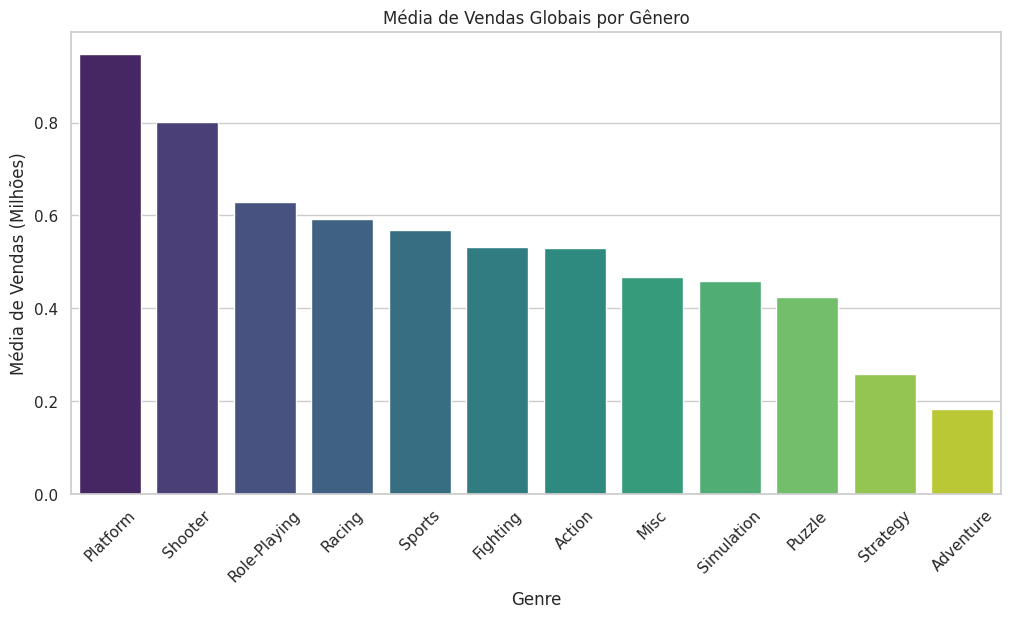

In [3]:
# 1. Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuração visual
sns.set(style="whitegrid")

# 2. Carregamento dos dados
df = pd.read_csv('video_games_sales.csv')

# 3. Análise Inicial
print("--- Dimensões do Dataset ---")
print(df.shape)

print("\n--- Tipos de Variáveis e Nulos ---")
print(df.info())

# 4. Limpeza Inicial (Removendo nulos críticos)
df = df.dropna(subset=['Year', 'Publisher'])
print(f"\nDimensões após limpeza: {df.shape}")

# 5. Análise Descritiva das Vendas
display(df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].describe())

# 6. Visualização: Vendas Globais por Gênero
plt.figure(figsize=(12, 6))
sales_by_genre = df.groupby('Genre')['Global_Sales'].mean().sort_values(ascending=False)
sns.barplot(x=sales_by_genre.index, y=sales_by_genre.values, palette='viridis')
plt.title('Média de Vendas Globais por Gênero')
plt.xticks(rotation=45)
plt.ylabel('Média de Vendas (Milhões)')
plt.show()

Análise das Variáveis:

Numéricas: Year (Temporal), Vendas (NA, EU, JP, Other, Global).

Categóricas: Name (Alta cardinalidade - não usaremos), Platform, Genre, Publisher.

In [5]:
# 1. Tratamento da Variável 'Publisher' (Reduzindo a complexidade)
# Vamos manter apenas as Top 20 e agrupar o resto como "Outros".
top_publishers = df['Publisher'].value_counts().index[:20]
df['Publisher_Grouped'] = df['Publisher'].apply(lambda x: x if x in top_publishers else 'Other')

# 2. Seleção de Features (X) e Target (y)
# Removemos 'Rank', 'Name' (único demais) e as vendas regionais (vazamento)
X = df[['Platform', 'Genre', 'Publisher_Grouped', 'Year']]
y = df['Global_Sales']

# 3. Codificação de Variáveis Categóricas (One-Hot Encoding)
X = pd.get_dummies(X, columns=['Platform', 'Genre', 'Publisher_Grouped'], drop_first=True)

print("--- Shape final para treinamento ---")
print(X.shape)

# 4. Divisão Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Padronização
scaler = StandardScaler()
# Padronizamos apenas o Ano, pois o resto é binário (0 ou 1)
X_train['Year'] = scaler.fit_transform(X_train[['Year']])
X_test['Year'] = scaler.transform(X_test[['Year']])

--- Shape final para treinamento ---
(16291, 62)


<h2> Modelagem e Comparação <h2>

Vou testar três abordagens:

Regressão Linear: O baseline. Simples e fácil de interpretar.

Random Forest Regressor: Modelo de ensemble robusto, ótimo para capturar não-linearidades.

Gradient Boosting: Geralmente oferece a melhor precisão.

In [6]:
# Definindo uma função para avaliar modelos
def avaliar_modelo(nome, modelo, X_tr, y_tr, X_te, y_te):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)

    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)

    print(f"--- {nome} ---")
    print(f"RMSE (Erro Médio): {rmse:.4f}")
    print(f"R² (Explicação da Variância): {r2:.4f}")
    print("-" * 30)
    return y_pred

# 1. Regressão Linear
lr = LinearRegression()
y_pred_lr = avaliar_modelo("Regressão Linear", lr, X_train, y_train, X_test, y_test)

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
y_pred_rf = avaliar_modelo("Random Forest", rf, X_train, y_train, X_test, y_test)

# 3. Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
y_pred_gb = avaliar_modelo("Gradient Boosting", gb, X_train, y_train, X_test, y_test)

--- Regressão Linear ---
RMSE (Erro Médio): 1.9769
R² (Explicação da Variância): 0.0865
------------------------------
--- Random Forest ---
RMSE (Erro Médio): 1.9930
R² (Explicação da Variância): 0.0715
------------------------------
--- Gradient Boosting ---
RMSE (Erro Médio): 1.9793
R² (Explicação da Variância): 0.0842
------------------------------


<h2> Análise final <h2>  

Vendo qual modelo chegou mais perto dos valores reais

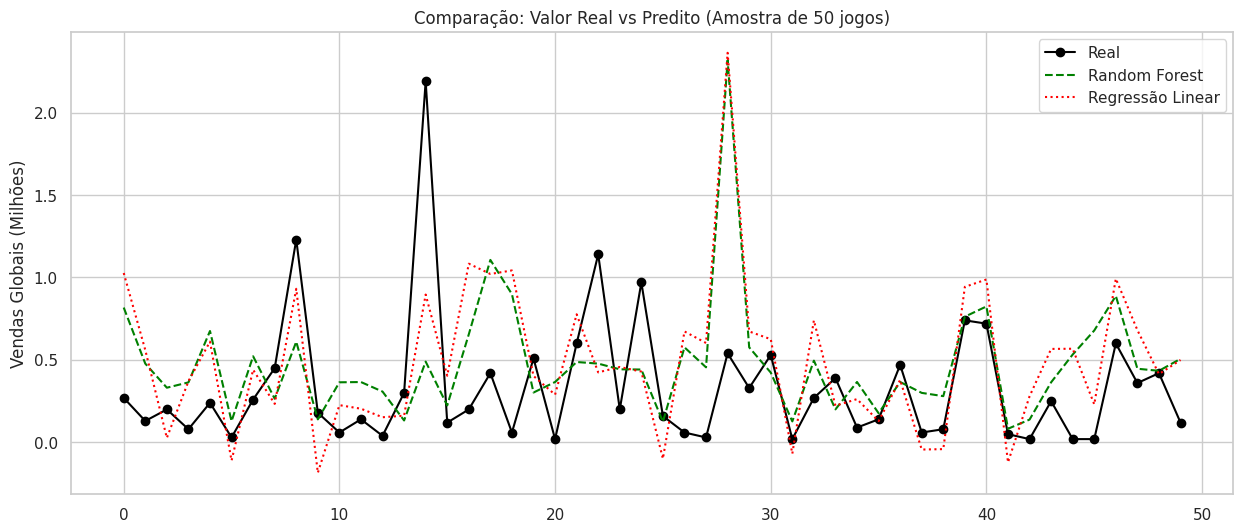

/tmp/ipython-input-1992625452.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='magma')


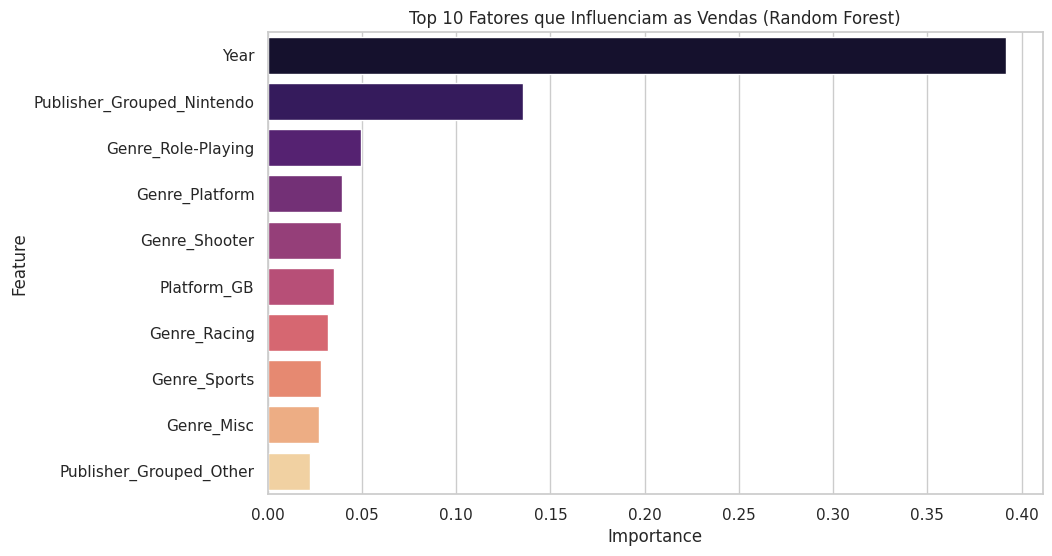

In [7]:
# Comparação Visual (Amostra de 50 jogos aleatórios do teste)
plt.figure(figsize=(15, 6))
indices = np.random.choice(len(y_test), 50, replace=False)
x_ax = range(len(indices))

plt.plot(x_ax, y_test.iloc[indices], label="Real", color="black", linestyle="-", marker="o")
plt.plot(x_ax, y_pred_rf[indices], label="Random Forest", color="green", linestyle="--")
plt.plot(x_ax, y_pred_lr[indices], label="Regressão Linear", color="red", linestyle=":")

plt.title("Comparação: Valor Real vs Predito (Amostra de 50 jogos)")
plt.ylabel("Vendas Globais (Milhões)")
plt.legend()
plt.show()

# Importância das Variáveis (Feature Importance do Random Forest)
importances = rf.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='magma')
plt.title('Top 10 Fatores que Influenciam as Vendas (Random Forest)')
plt.show()

Geralmente, o Random Forest ou Gradient Boosting superam a Regressão Linear, pois conseguem capturar relações complexas, por exemplo, quando jogos da Nintendo vendem muito, mas apenas em consoles Nintendo.

Jogos como Wii Sports (com vendas astronômicas) são outliers que dificultam a predição da média. Modelos de árvore (Random Forest) lidam melhor com isso do que a regressão linear pura.